In [1]:
import numpy as np, matplotlib.pyplot as plt, os
from glob import glob
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel

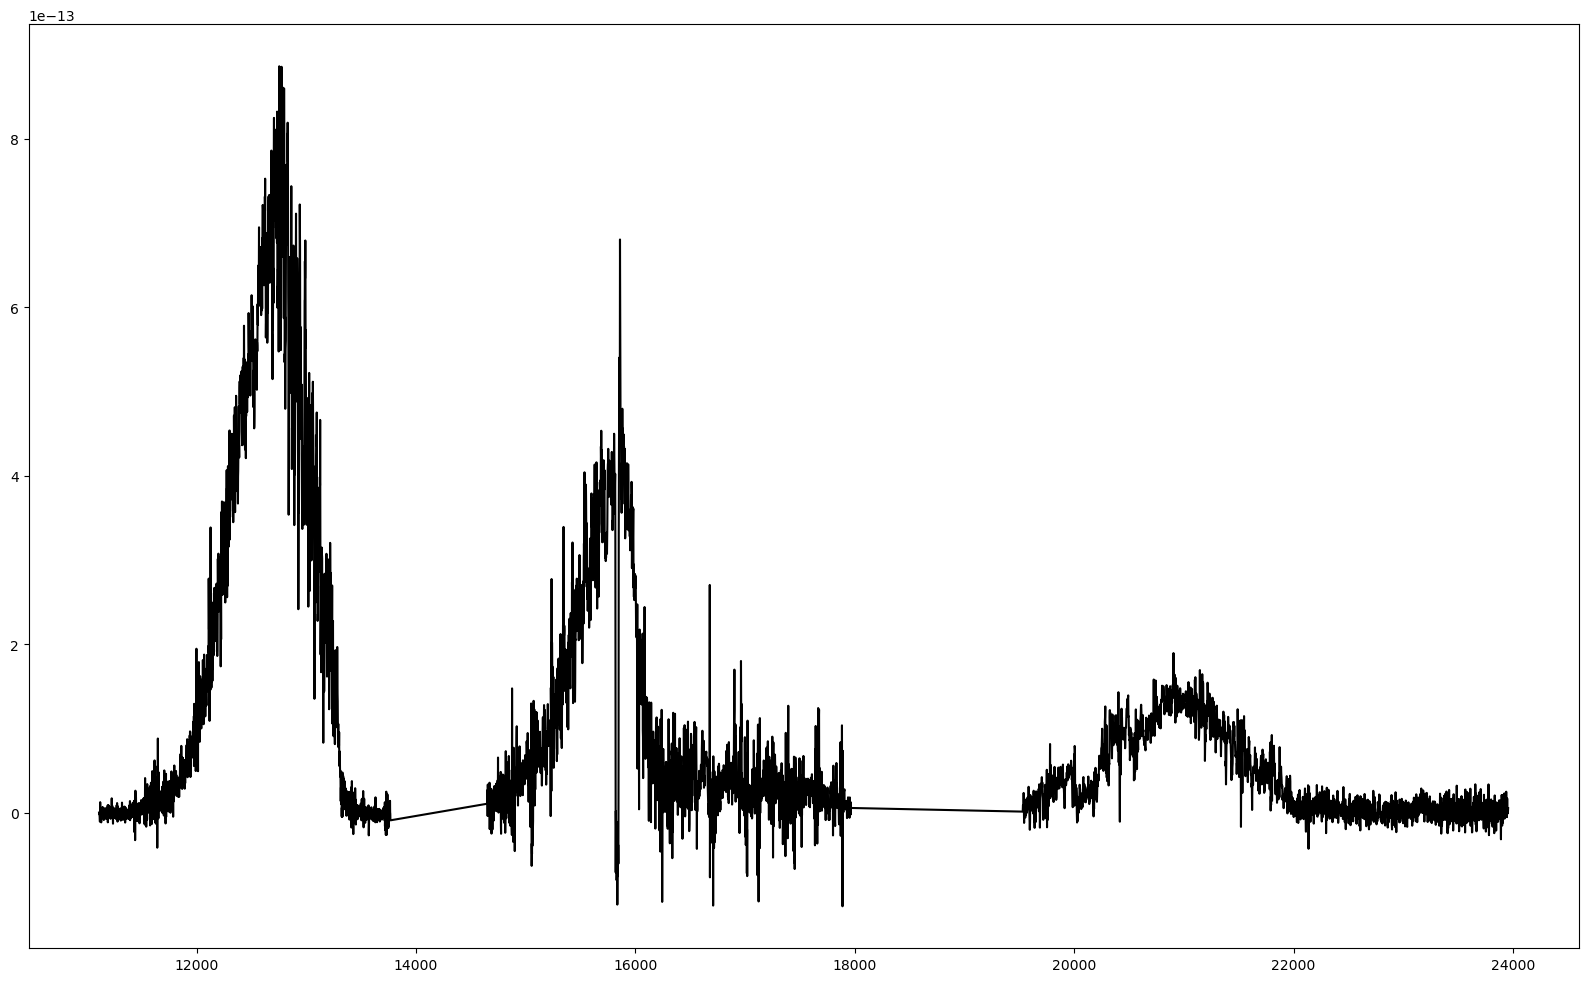

In [2]:
data = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
waveA = data[:, 0]
#fluxA = data[:, 1] / 10000
fluxA = data[:, 1]
unc = data[:, 2]

plt.figure(figsize = (20, 12))
plt.plot(waveA, fluxA, color = 'black')

In [3]:
target = 'WISE J225540.75-311842.0'

file_name = '/Users/bseamons/Documents/Research/Flux_cal_JHK_2M2255-3118.txt'

bt_path = '/Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/'
bt_models = glob(os.path.join(bt_path, '*.7.dat.txt'))

spex_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spextra = glob(os.path.join(spex_path, '*.spex.txt'))

atmo_path = '/Users/bseamons/Documents/Research/atmo_models/'
atmo_models = glob(os.path.join(atmo_path, '*.dat'))

R = (3318 + 3660 + 3610) / 3 # average MOSFIRE resolution over the J, H, and K bands

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_11273/4027313794.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_minG[0])


Minimum C value:         [6.40109879e-20]
Minimum G value:         31627.134866091055
Best fit BT-Settl model: /Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/lte006-3.5-0.0.BT-Settl.7.dat.txt


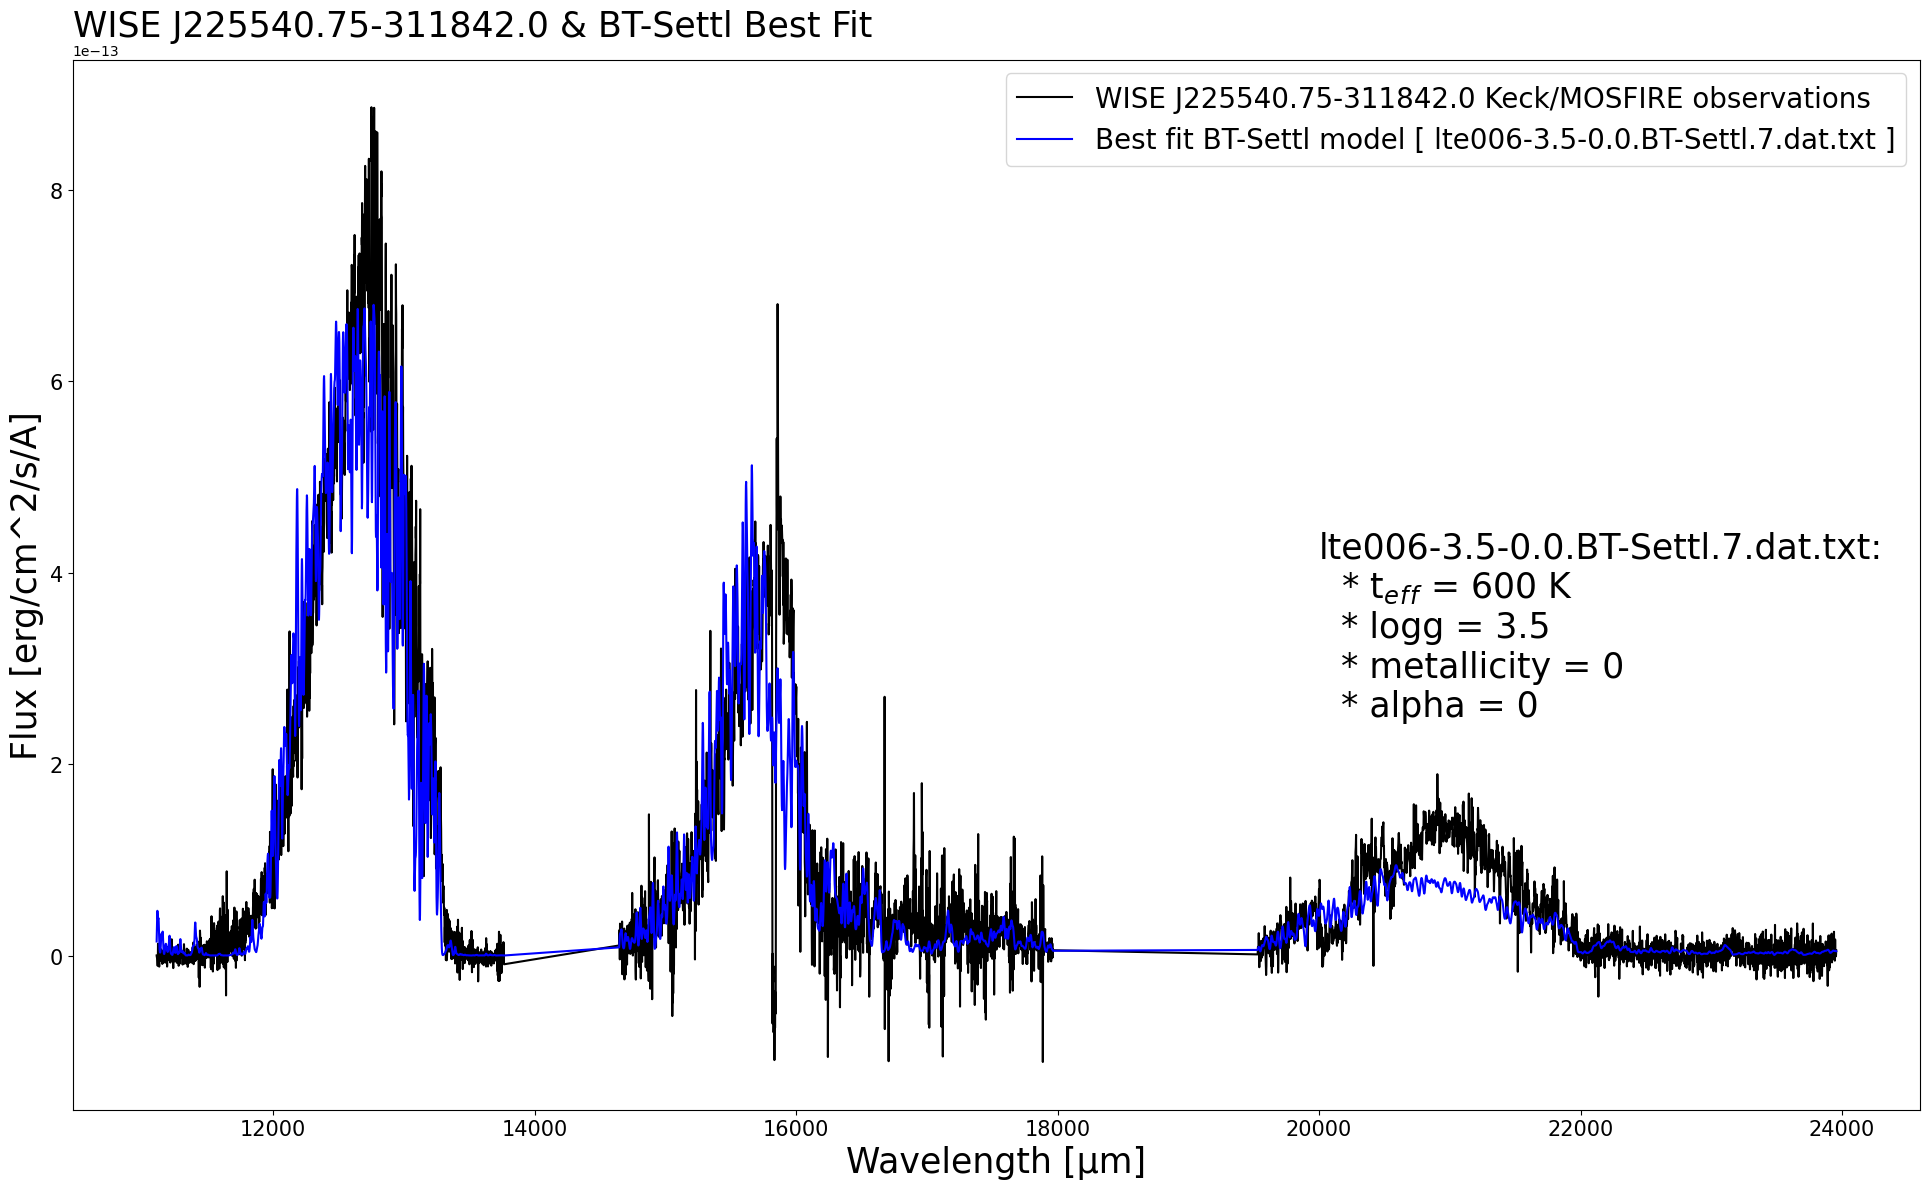

In [4]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1: -1] + w_loggrid[0: -2]) / (w_loggrid[1: -1] - w_loggrid[0: -2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

def bestfit(obs_path, mod_path, t, res, modelname, var):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * minC: int - the minimum C value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * Currently set up to find model files ending in '.dat.txt', though that can be altered with a simple change to
          the 'models' line
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1]
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.dat.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
                           
    for i in range(len(models)):
        data = np.loadtxt(models[i])
        wave = np.where((data[:, 0] > wave_obs[0]) & (data[:, 0] < wave_obs[-1]))

        wl = data[wave, 0][0]
        flux = data[wave, 1][0] * 1e4

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs - C[i] * low_mod[i, 1, :]) / unc_obs) ** 2)

    ## Calculate the minima in C and G
    minG = np.min(G)
    where_minG = np.where(G == minG)
    minC = C[where_minG]

    ## Index minG to the correct model
    modindex = int(where_minG[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Plot the best fit model with the observational data
    if var == 1:
        print(f'Minimum C value:         {minC}')
        print(f'Minimum G value:         {minG}')
        print(f'Best fit {modelname} model: {bestmodel}')
        plt.figure(figsize = (20, 12))
        plt.plot(wave_obs, flux_obs, color = 'black', label = target + ' Keck/MOSFIRE observations')
        plt.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * minC, color = 'blue', label = f'Best fit {modelname} model [ {bestmodel[69:]} ]')
        plt.title(target + f' & {modelname} Best Fit', loc = 'left', fontsize = 25)
        plt.xlabel('Wavelength [µm]', fontsize = 25)
        plt.ylabel('Flux [erg/cm^2/s/A]', fontsize = 25)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
        plt.annotate(f'{bestmodel[69:]}:\n  * t$_e$$_f$$_f$ = 600 K\n  * logg = 3.5\n  * metallicity = 0\n  * alpha = 0', (20000, 2.5e-13), fontsize = 25)
        plt.tight_layout()
        #plt.savefig('Best fit BT-Settl model and observations')
    elif var == 2:
        plt.figure(figsize = (20, 12))
        plt.errorbar(wave_obs, flux_obs, yerr = unc, color = 'black', ecolor = 'red', marker = 's', markersize = 3, linewidth = 1, fmt = '.')
        plt.title(target + ' Observations and Error', loc = 'left', fontsize = 25)
        plt.xlabel('Wavelength [µm]', fontsize = 25)
        plt.ylabel('Flux [erg/cm^2/s/A]', fontsize = 25)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.tight_layout()
        #plt.savefig('Observations withe error')
    else:
        print("Please enter the needed input for 'var': 1 for observations vs. model or 2 for observations with error.")

    return

bestfit(file_name, bt_path, target, R, 'BT-Settl', 1) 

In [166]:
def convolve(wl_mod, spec, R, var, sample = 1):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        # wl_mod: array (the model wavelengths, in this case models[0][0]
        * sp: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * var: user input (int) (input 1 to return only the smoothed grid, 2 to return both the original and smoothed grids)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * sp: the convolved spectrum (and possibly the original grid)
    * Notes:
        * This iteration will need spec to have a shape (model #, datapoints) (i.e. np.shape(modelflux)) = (31, 51888))
    '''
    # Save the original wavelength grid and units
    w_grid = spec
    w_grid = wl_mod
    flux = spec[0]

    # Convert inputs to numpy arrays
    w_grid = np.array(wl_mod)
    flux = np.array(spec)

    # Remove non-positive values from w_grid
    valid_indices = np.where(w_grid > 0)
    w_grid = w_grid[valid_indices]
    flux = flux[valid_indices]

    # Generate a logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid) * sample
    w_log = np.logspace(w_logmin, w_logmax, num = n_w)

    # Find the standard deviation of the Gaussian kernel for smoothing
    R_grid = (w_log[1:-1] + w_log[0:-2]) / (w_log[1:-1] - w_log[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    # Interpolate onto a logarithmic grid
    f_log = np.interp(w_log, w_grid, flux)

    # Smooth and convolve with the Gaussian kernel
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate everything back onto the original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)
    smooth_sp = np.vstack([w_grid, f_sm])

    #print(len(w_grid), len(flux))
    #print(len(wl_mod), len(spec))

    # Write the smoothed spectrum back into the spectrum object
    if var == 1:
        return f_sm
    if var == 2:
        return smooth_sp

w_spex = []
f_spex = []
post_interp_spex = []
for i in range(len(spextra)):
    model = np.loadtxt(spextra[i])
    w.append(model[:, 0] * 1e4)
    f.append(model[:, 1])
    pre_interp = interpolate.interp1d(w[i], f[i])
    post_interp_spex.append(pre_interp(waveA) * fluxA)

spex_smooth = []
for i in range(len(post_interp_spex)):
    sm_mod = post_interp_spex[i]
    spex_smooth.append(convolve(waveA, sm_mod, R, 1))

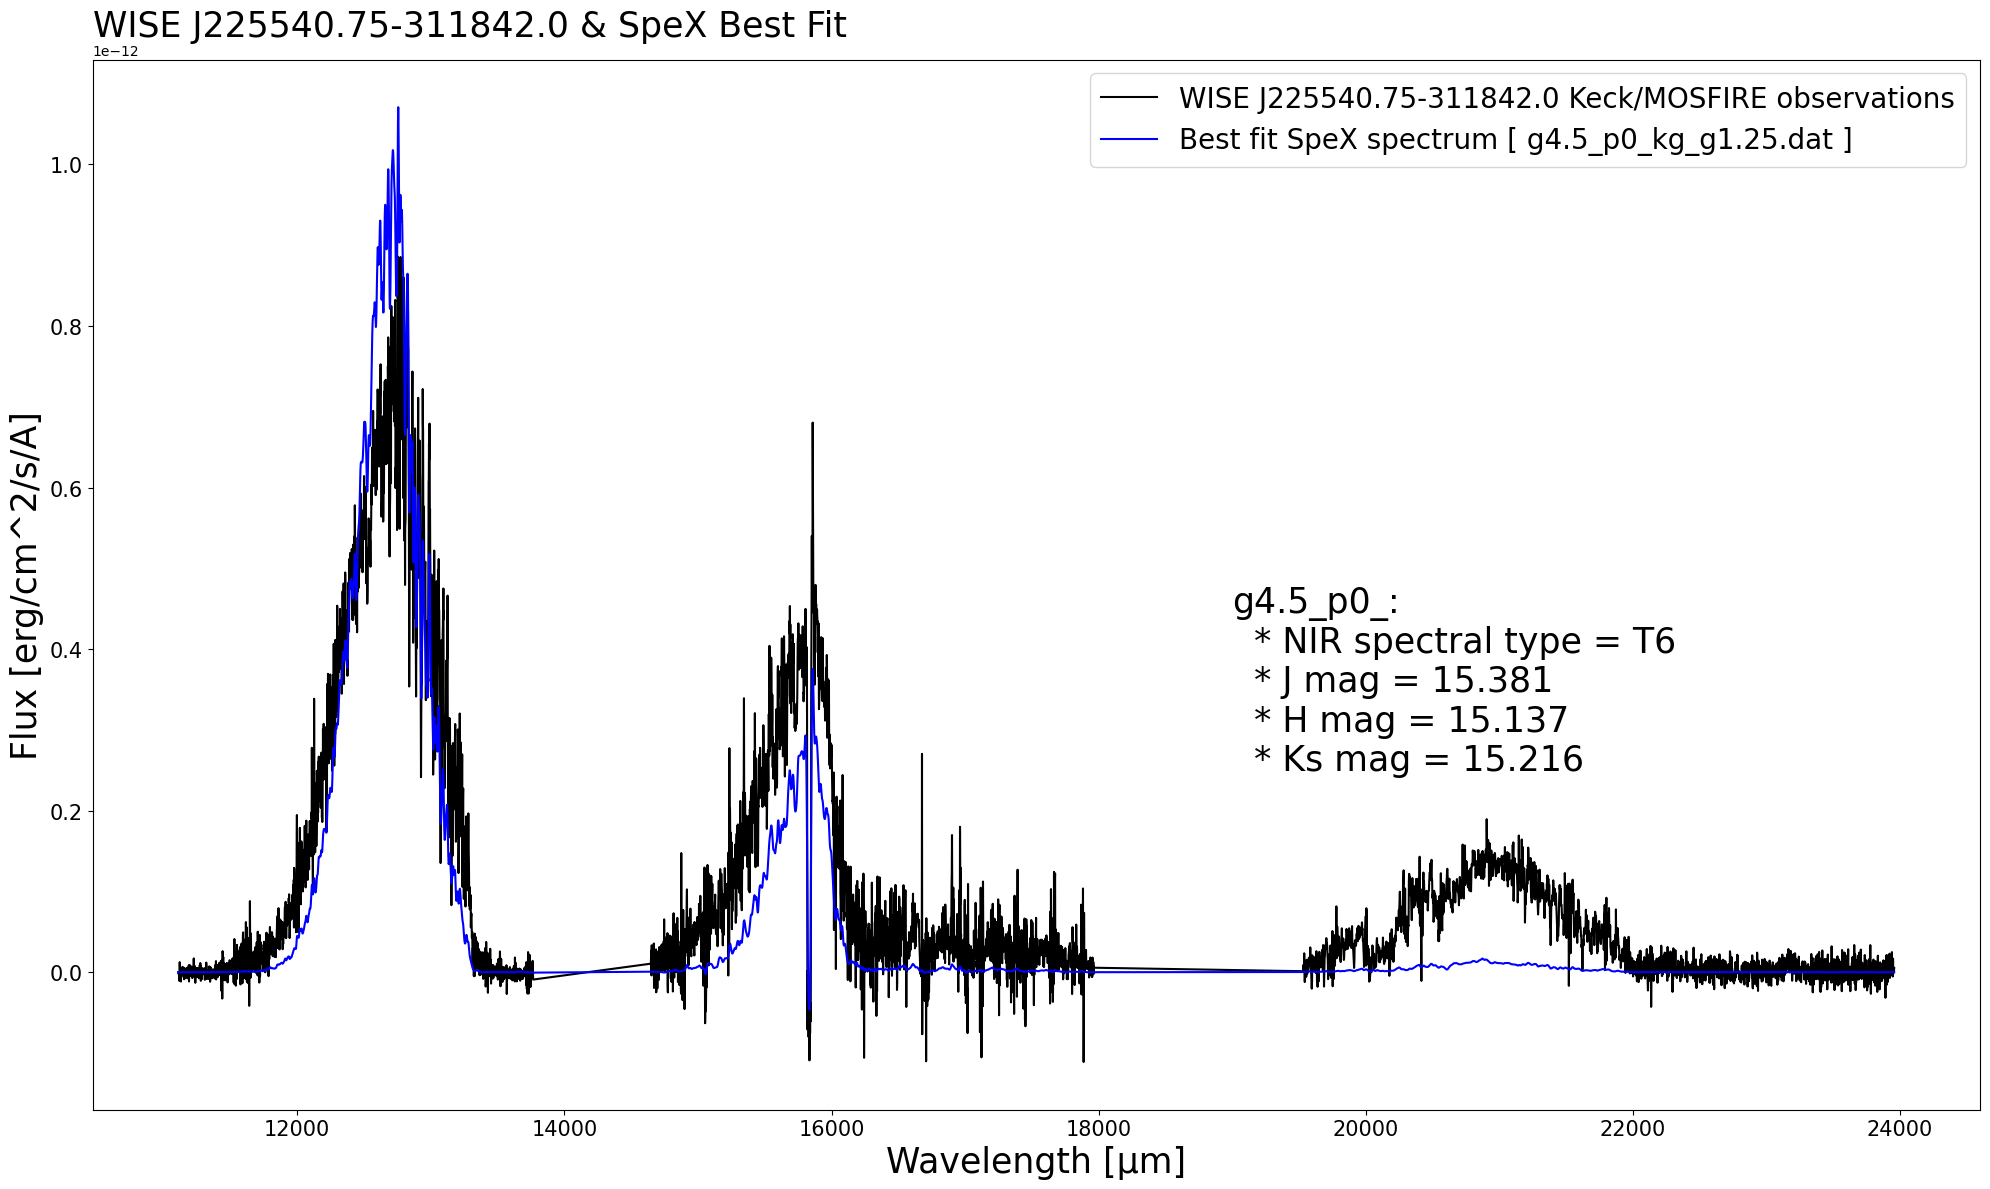

In [167]:
C_spex = []
G_spex = []
for i in range(len(spextra)):
    C_spex.append((np.nansum((fluxA * spex_smooth[i]) / unc ** 2)) / (np.nansum(spex_smooth[i] ** 2 / unc ** 2)))
    G_spex.append(np.nansum(((fluxA - C[i] * spex_smooth[i]) / unc) ** 2))

Gmin_spex = np.argmin(G_spex)
Cmin_spex = C[Gmin_spex]
modindex_spex = int(Gmin_spex)
bestfit_spex = np.loadtxt(spextra[modindex_spex])
bestmodel_spex = spextra[modindex_spex]

plt.figure(figsize = (20, 12))
plt.plot(waveA, fluxA, color = 'black', label = target + ' Keck/MOSFIRE observations')
plt.plot(waveA, spex_smooth[modindex] * Cmin_spex, color = 'blue', label = f'Best fit SpeX spectrum [ {bestmodel_spex[68:]} ]')

plt.title(target + ' & SpeX Best Fit', loc = 'left', fontsize = 25)
plt.xlabel('Wavelength [µm]', fontsize = 25)
plt.ylabel('Flux [erg/cm^2/s/A]', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
plt.annotate(f'{bestmodel[68:-12]}:\n  * NIR spectral type = T6\n  * J mag = 15.381\n  * H mag = 15.137\n  * Ks mag = 15.216', (19000, 2.5e-13), fontsize = 25)
plt.tight_layout()
plt.savefig('Best fit SpeX spectrum and observations')

In [168]:
def convolve_atmo(wl_mod, spec, R, var, sample = 1):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        # wl_mod: array (the model wavelengths, in this case models[0][0]
        * sp: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * var: user input (int) (input 1 to return only the smoothed grid, 2 to return both the original and smoothed grids)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * sp: the convolved spectrum (and possibly the original grid)
    * Notes:
        * This iteration will need spec to have a shape (model #, datapoints) (i.e. np.shape(modelflux)) = (31, 51888))
    '''
    # Save the original wavelength grid and units
    w_grid = spec
    w_grid = wl_mod
    flux = spec[0]

    # Convert inputs to numpy arrays
    w_grid = np.array(wl_mod)
    flux = np.array(spec)

    # Remove non-positive values from w_grid
    valid_indices = np.where(w_grid > 0)
    w_grid = w_grid[valid_indices]
    flux = flux[valid_indices]

    # Generate a logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid) * sample
    w_log = np.logspace(w_logmin, w_logmax, num = n_w)

    # Find the standard deviation of the Gaussian kernel for smoothing
    R_grid = (w_log[1:-1] + w_log[0:-2]) / (w_log[1:-1] - w_log[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    # Interpolate onto a logarithmic grid
    f_log = np.interp(w_log, w_grid, flux)

    # Smooth and convolve with the Gaussian kernel
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate everything back onto the original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)
    smooth_sp = np.vstack([w_grid, f_sm])

    #print(len(w_grid), len(flux))
    #print(len(wl_mod), len(spec))

    # Write the smoothed spectrum back into the spectrum object
    if var == 1:
        return f_sm
    if var == 2:
        return smooth_sp

w_atmo = []
f_atmo = []
post_interp_atmo = []
for i in range(len(atmo_models)):
    model = np.loadtxt(atmo_models[i])
    w_atmo.append(model[:, 0] * 1e4)
    f_atmo.append(model[:, 1])
    pre_interp = interpolate.interp1d(w_atmo[i], f_atmo[i])
    post_interp_atmo.append(pre_interp(waveA))

atmo_smooth = []
for i in range(len(post_interp_atmo)):
    sm_mod = post_interp_atmo[i]
    atmo_smooth.append(convolve_atmo(waveA, sm_mod, R, 1))

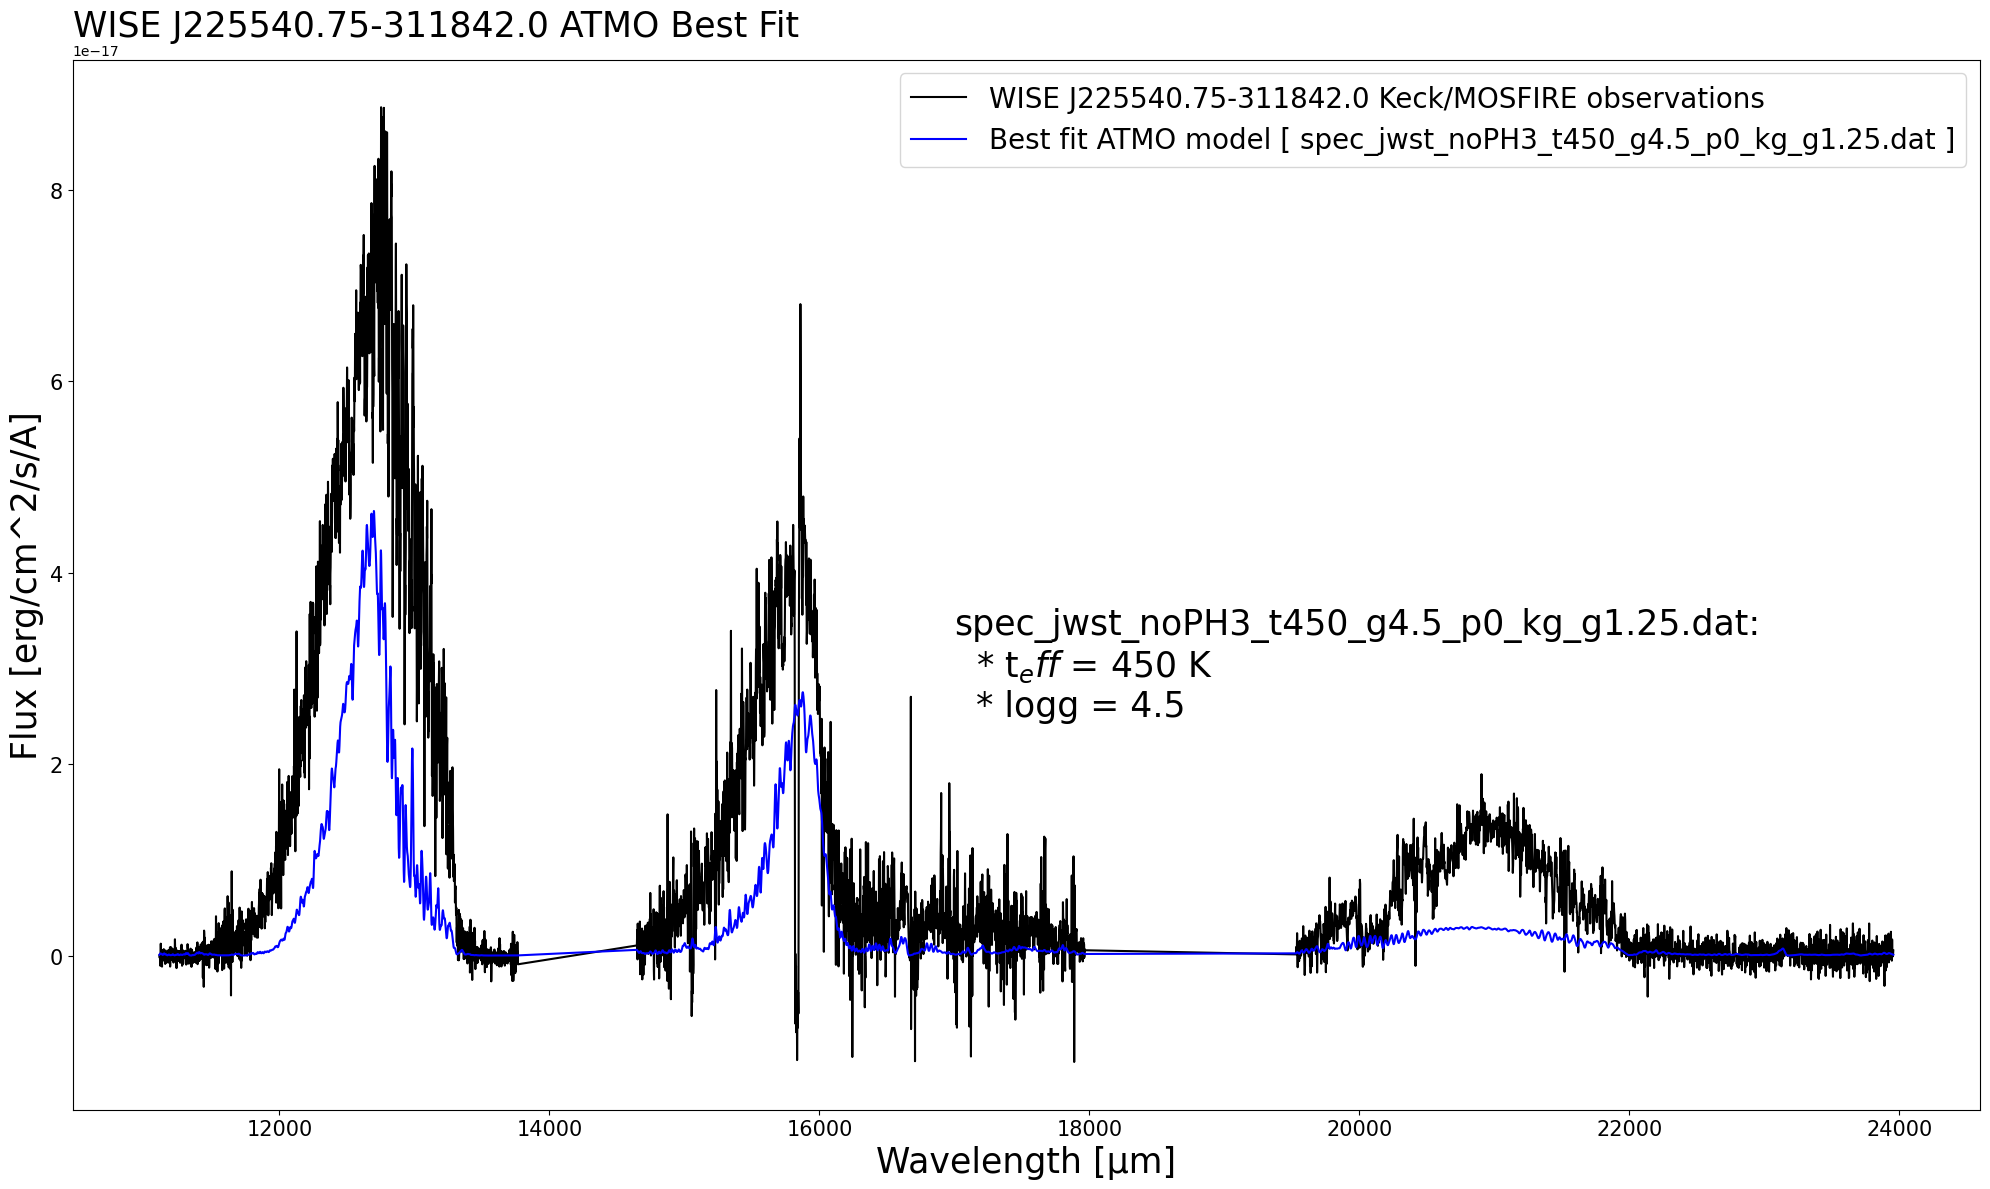

In [169]:
C_atmo = []
G_atmo = []
for i in range(len(atmo_models)):
    C_atmo.append((np.nansum((fluxA * atmo_smooth[i]) / unc ** 2)) / (np.nansum(atmo_smooth[i] ** 2 / unc ** 2)))
    G_atmo.append(np.nansum(((fluxA - C_atmo[i] * atmo_smooth[i]) / unc) ** 2))

Gmin_atmo = np.argmin(G_atmo)
Cmin_atmo = C[Gmin_atmo]
modindex_atmo = int(Gmin_atmo)
bestfit_atmo = np.loadtxt(atmo_models[modindex_atmo])
bestmodel_atmo = atmo_models[modindex_atmo]

plt.figure(figsize = (20, 12))
plt.plot(waveA, fluxA / 10000, color = 'black', label = target + ' Keck/MOSFIRE observations')
plt.plot(waveA, atmo_smooth[modindex_atmo] * Cmin_atmo, color = 'blue', label = f'Best fit ATMO model [ {bestmodel_atmo[47:]} ]')

plt.title(target + ' ATMO Best Fit', loc = 'left', fontsize = 25)
plt.xlabel('Wavelength [µm]', fontsize = 25)
plt.ylabel('Flux [erg/cm^2/s/A]', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
plt.annotate(f'{bestmodel[47:88]}:\n  * t$_e$$f$$f$ = 450 K\n  * logg = 4.5', (17000, 2.5e-17), fontsize = 25)
plt.tight_layout()
#plt.savefig('Best fit ATMO model and observations')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_14138/2692305506.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_minG[0])


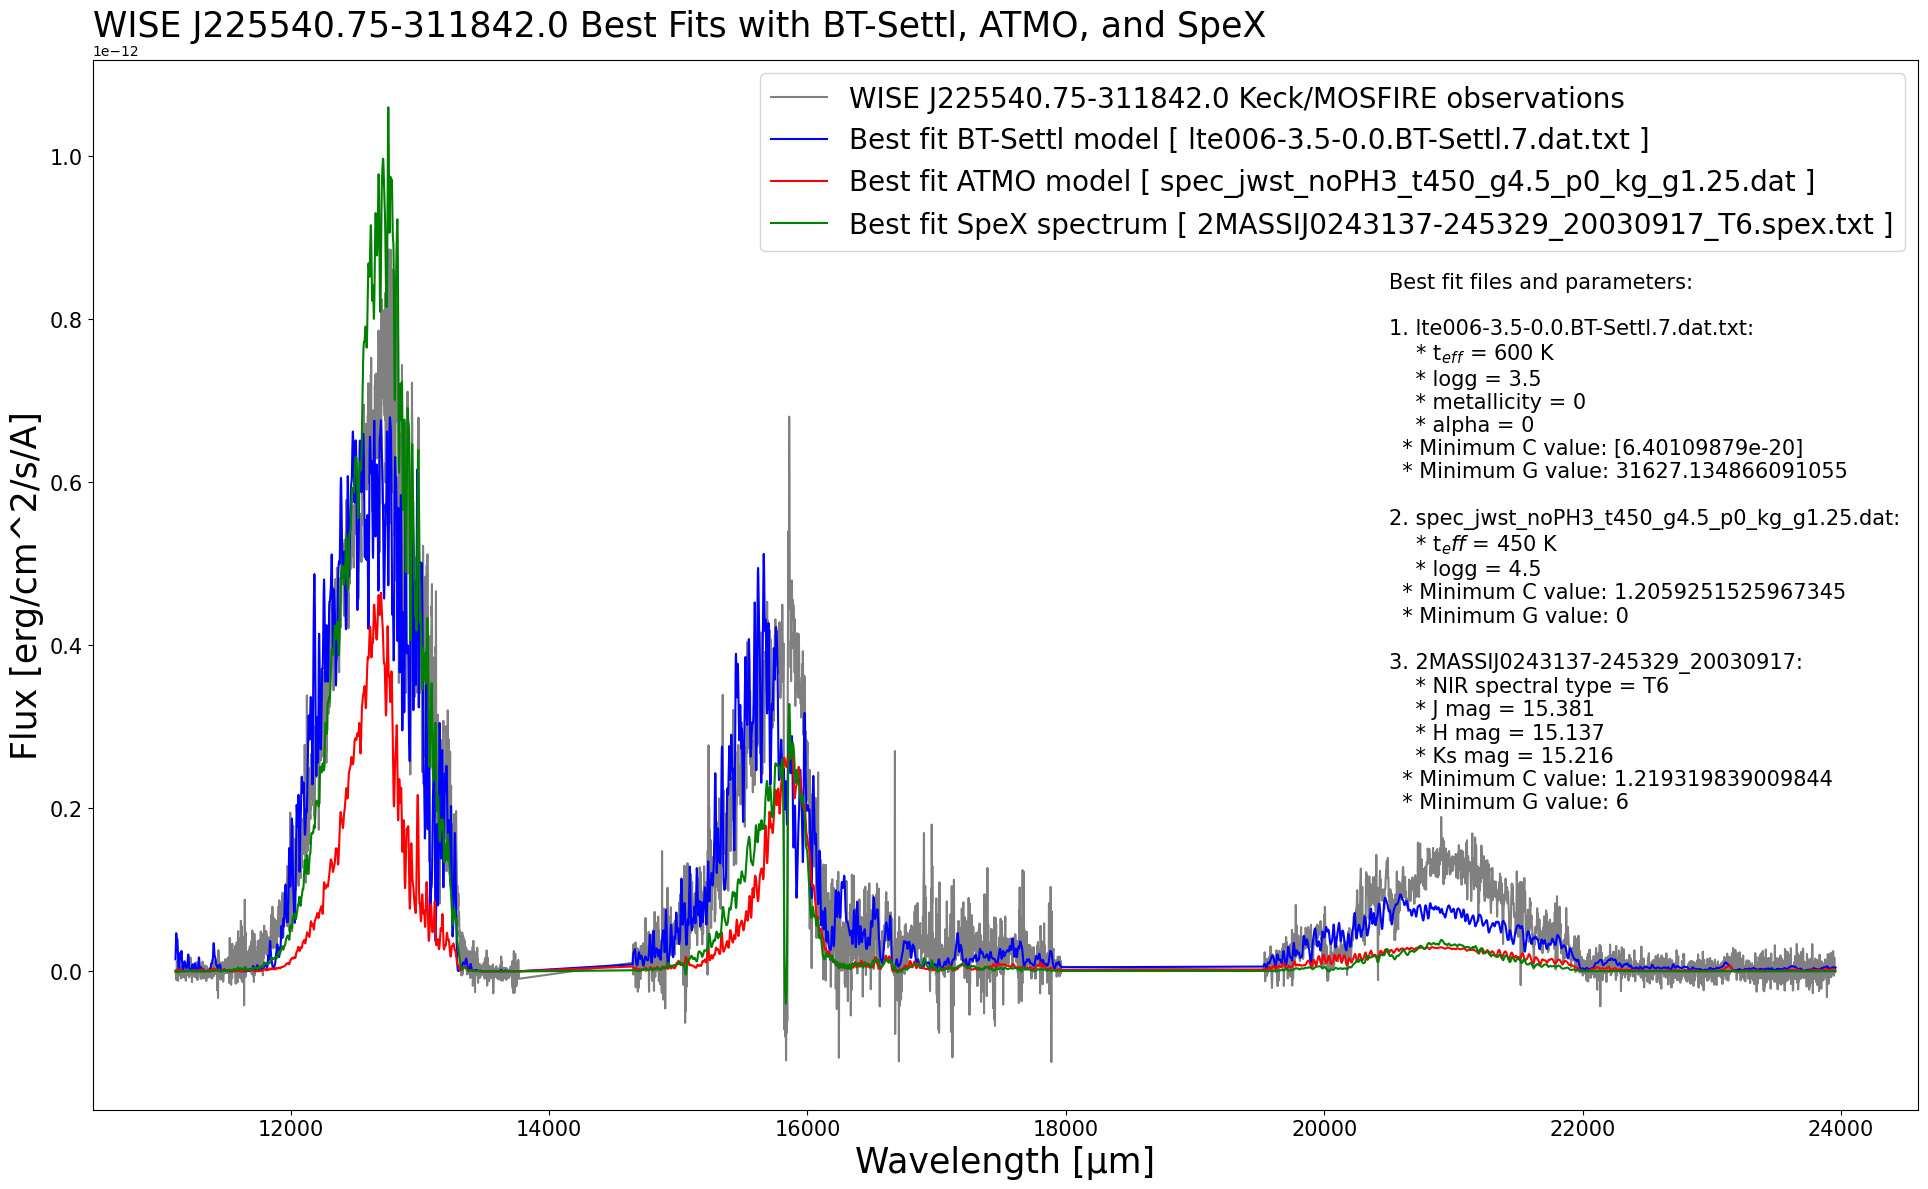

In [211]:
def plotemall(obs_path, mod_path, t, res, modelname, f_atmo, index_atmo, C_atmo, G_atmo, model_atmo, f_spex, index_spex, C_spex, G_spex, model_spex):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * minC: int - the minimum C value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * Currently set up to find model files ending in '.dat.txt', though that can be altered with a simple change to
          the 'models' line
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1]
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.dat.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
                           
    for i in range(len(models)):
        data = np.loadtxt(models[i])
        wave = np.where((data[:, 0] > wave_obs[0]) & (data[:, 0] < wave_obs[-1]))

        wl = data[wave, 0][0]
        flux = data[wave, 1][0] * 1e4

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs - C[i] * low_mod[i, 1, :]) / unc_obs) ** 2)

    ## Calculate the minima in C and G
    minG = np.min(G)
    where_minG = np.where(G == minG)
    minC = C[where_minG]

    ## Index minG to the correct model
    modindex = int(where_minG[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    plt.plot(wave_obs, flux_obs, color = 'gray', label = target + ' Keck/MOSFIRE observations')
    
    plt.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * minC, color = 'blue', label = f'Best fit {modelname} model [ {bestmodel[69:]} ]')
    plt.plot(wave_obs, f_atmo[index_atmo] * C_atmo * 1e4, color = 'red', label = f'Best fit ATMO model [ {model_atmo[47:]} ]')
    plt.plot(wave_obs, f_spex[index_spex] * C_spex, color = 'green', label = f'Best fit SpeX spectrum [ {model_spex[68:]} ]')
    
    plt.title(target + f' Best Fits with BT-Settl, ATMO, and SpeX', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm^2/s/A]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
    #plt.annotate(f'{bestmodel[69:]}:\n  * t$_e$$_f$$_f$ = 600 K\n  * logg = 3.5\n  * metallicity = 0\n  * alpha = 0', (20000, 2.5e-13), fontsize = 25)
    plt.annotate(f'Best fit files and parameters:\n\n1. {bestmodel[69:]}:\n    * t$_e$$_f$$_f$ = 600 K\n    * logg = 3.5\n    * metallicity = 0\n    * alpha = 0\n  * Minimum C value: {minC}\n  * Minimum G value: {minG}\n\n2. {model_atmo[47:88]}:\n    * t$_e$$f$$f$ = 450 K\n    * logg = 4.5\n  * Minimum C value: {C_atmo}\n  * Minimum G value: {G_atmo}\n\n3. {model_spex[68:-12]}:\n    * NIR spectral type = T6\n    * J mag = 15.381\n    * H mag = 15.137\n    * Ks mag = 15.216\n  * Minimum C value: {C_spex}\n  * Minimum G value: {G_spex}', (20500, 0.2e-12), fontsize = 15)  
    plt.tight_layout()
    #plt.savefig('WISE J225540 Best Fits')

    return

plotemall(file_name, bt_path, target, R, 'BT-Settl', atmo_smooth, modindex_atmo, Cmin_atmo, Gmin_atmo, bestmodel_atmo, spex_smooth, modindex_spex, Cmin_spex, Gmin_spex, bestmodel_spex)